# Spreading over time

Noreen suggested that peaks were spreading even pre-pandemic, and we want to make sure that our results aren't just a continuation of an existing trend.

In [45]:
using Revise
using Plots
using DataFrames
using Dates
using StatsBase, Statistics
using GLM

In [4]:
includet("../code/KFactors.jl")

In [5]:
using .KFactors

In [6]:
data = read_data("../data/all_district_peaks.parquet", "../data/sensor_meta_geo.csv")

┌ Info: Observations in each period
│   combine(groupby(data, :period), nrow) = 3×2 DataFrame
 Row │ period        nrow    
     │ Cat…          Int64   
─────┼───────────────────────
   1 │ pandemic       365083
   2 │ postpandemic   338894
   3 │ prepandemic   1371886
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:91
┌ Info: Before filtering, data has 2075863 rows
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:102
┌ Info: Removing sensors days with peak-hour occ above 99th percentile (0.22%)
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:130
┌ Info: After filtering, data has 961571 rows
└ @ Main.KFactors /Users/mwbc/git/peak-spreading/code/KFactors.jl:134


,station,peak_hour_occ,peak_hour_flow,occ_entropy,total_occ,total_flow,station_type
,Int64?,Float64?,Float64?,Float64?,Float64?,Int64?,String?
1,312010,0.0993812,0.0532605,7.89354,30.0741,124445,ML
2,312098,0.196265,0.0679414,7.61211,16.2056,76301,ML
3,312103,0.10535,0.0606239,7.76368,26.3512,108967,ML
4,312132,0.0794718,0.0745055,7.96612,12.987,27555,ML
5,312134,0.128285,0.0619238,7.91013,21.2293,37094,ML
6,312139,0.105051,0.0592375,7.83104,28.2015,129293,ML
7,312326,0.074277,0.0737793,7.89587,13.1804,34305,ML
8,312346,0.0796166,0.0745147,7.89865,15.2732,65477,ML
9,312386,0.175833,0.0522122,7.76517,19.6516,62744,ML


In [11]:
data.year = Dates.year.(data.date), labve;

In [43]:
avg_by_year = combine(groupby(data, :year), :peak_hour_occ => mean, :peak_hour_occ=>std, nrow=>:size)

,year,peak_hour_occ_mean,peak_hour_occ_std,size
,Int64,Float64,Float64,Int64
1,2016,0.0975129,0.032978,154713
2,2017,0.0969275,0.0329144,156528
3,2018,0.0958691,0.0321831,161095
4,2019,0.0962724,0.0325885,163445
5,2020,0.0858169,0.0255383,165459
6,2021,0.0898043,0.0284936,160331


In [28]:
data = transform(groupby(data, :year), :date => minimum, :date => maximum);

In [30]:
data.yearx = data.year .- 0.5 .+ (Dates.dayofyear.(data.date) .- Dates.dayofyear.(data.date_minimum)) ./ (Dates.dayofyear.(data.date_maximum) .- Dates.dayofyear.(data.date_minimum));

In [58]:
mod = lm(@formula(peak_hour_occ_mean ~ year), avg_by_year[avg_by_year.year .<= 2019, :])

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

peak_hour_occ_mean ~ 1 + year

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                    Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)   1.06097      0.419128      2.53    0.1270  -0.742395    2.86433
year         -0.000477978  0.000207746  -2.30    0.1481  -0.00137184  0.000415881
─────────────────────────────────────────────────────────────────────────────────

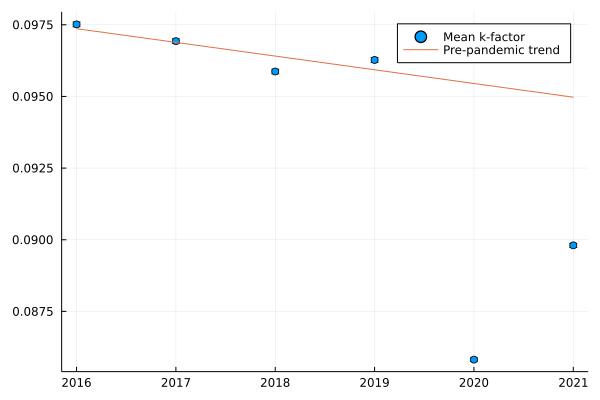

In [59]:
scatter(avg_by_year.year, avg_by_year.peak_hour_occ_mean, label="Mean k-factor", yerror=avg_by_year.peak_hour_occ_std ./ sqrt.(avg_by_year.size))
plot!(avg_by_year.year, predict(mod, avg_by_year), label="Pre-pandemic trend")

In [61]:
diffmod = lm(@formula(peak_hour_occ ~ year + (year == 2020) + (year == 2021)), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

peak_hour_occ ~ 1 + year + :(year == 2020) + :(year == 2021)

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                     Coef.   Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)    1.05396      0.069859      15.09    <1e-50   0.91704       1.19088
year          -0.000474506  3.46261e-5   -13.70    <1e-42  -0.000542372  -0.00040664
year == 2020  -0.00964161   0.000120865  -79.77    <1e-99  -0.0098785    -0.00940472
year == 2021  -0.00517977   0.000148082  -34.98    <1e-99  -0.00547      -0.00488953
────────────────────────────────────────────────────────────────────────────────────

165459